## Example of Training a Neural Network

We will be training a neural network using a modified version of the VAE network. By elmininating the term on the loss function and setting epsilon equal to zero, we arrive at an autoencoder framework that reconstructs hand-written digits. 

In [1]:
import sklearn.datasets
import matplotlib.pyplot as plt 
from VAE import VAE
% matplotlib inline

In [2]:
digits = sklearn.datasets.load_digits()

After we import the VAE class, we set up the parameters and intialize the weights.  

In [3]:
params = {
    'alpha' : 0.1,
    'activation' : 1,
    'loss' : 1,
    'max_iter' : 100
}

example = VAE([64, 20], [64, 20], params)

### Training on Digits

Here we pass in two training digits of size 8 by 8 pixels.

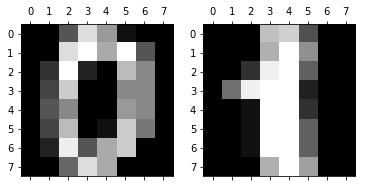

In [4]:
in_digit = digits.data[0:2]
fig, ax = plt.subplots(1,2)
ax[0].matshow(in_digit[0].reshape((8,8)), cmap = 'gray')
ax[1].matshow(in_digit[1].reshape((8,8)), cmap = 'gray')
pass

We intialize the weights to be random, so the first pass looks jumbled.

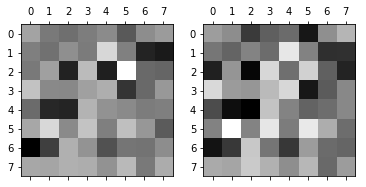

In [5]:
out_digit = example.feedforward(in_digit)
fig, ax = plt.subplots(1,2)
ax[0].matshow(out_digit[0].reshape((8,8)), cmap = 'gray')
ax[1].matshow(out_digit[1].reshape((8,8)), cmap = 'gray')
pass

We then train the network to reduce the loss function and reproduce the images. 

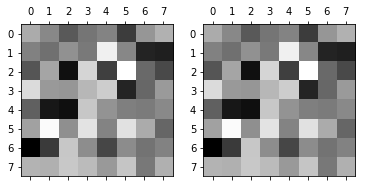

In [8]:
out_trained = example.train(out_digit)
fig, ax = plt.subplots(1,2)
ax[0].matshow(out_trained[0].reshape((8,8)), cmap = 'gray')
ax[1].matshow(out_trained[1].reshape((8,8)), cmap = 'gray')
pass